In [118]:
import pandas as pd
import geopandas as gpd
import numpy as np
import re
#załadowanie mapy gmin
#źródło: https://www.geoportal.gov.pl/dane/panstwowy-rejestr-granic
gminy_map=gpd.read_file('data/A03_Granice_gmin.shp',encoding='utf-8')
gminy_map=gminy_map[['JPT_KOD_JE','JPT_NAZWA_','geometry']]
gminy_map['JPT_KOD_JE']=gminy_map['JPT_KOD_JE'].apply(lambda x: int(x))

In [119]:
#ładowanie danych GUS o liczbie mieszkańców, liczbie bezrobotnych i dochodzie na mieszkańca w gminach 
rynek_gmin=pd.read_csv('data/RYNE_3733_CTAB_20230217183531.csv',delimiter=';')
pop_gmin=pd.read_csv('data/LUDN_2137_CTAB_20230217185151.csv',delimiter=';')
fin_gmin=pd.read_csv('data/FINA_2627_CTAB_20230217185738.csv',delimiter=';')


#jako bezrobotny może się zarejestrować jedynie osoba pełnoletnia nieprzekraczająca wieku emerytalnego
#niestety dysponuję widełkami wiekowymi 15-19 oraz 20-24, czyli nie jestem w stanie dokładnie odfiltrować pełnoletnich
#dla łatwości obliczeń zakładam, że w przedziale 15-19 wiek ludzi ma rozkład jednostajny więc biorę z niego 40%
pop_gmin['18-24']=round(pop_gmin['15-19;ogółem;2020;[osoba]']*0.4)+pop_gmin['20-24;ogółem;2020;[osoba]']
pop_gmin['18-29']=pop_gmin['18-24']+pop_gmin['25-29;ogółem;2020;[osoba]']
pop_gmin['pow50']=pop_gmin['50-54;ogółem;2020;[osoba]']+pop_gmin['55-59;ogółem;2020;[osoba]']+pop_gmin['60-64;mężczyźni;2020;[osoba]']
pop_gmin['all']=pop_gmin['ogółem;ogółem;2020;[osoba]']-pop_gmin['0-14;ogółem;2020;[osoba]']-round(pop_gmin['15-19;ogółem;2020;[osoba]']*0.6)-pop_gmin['70 i więcej;ogółem;2020;[osoba]']-pop_gmin['65-69;ogółem;2020;[osoba]']-pop_gmin['60-64;kobiety;2020;[osoba]']
pop_gmin['k']=pop_gmin['ogółem;kobiety;2020;[osoba]']-pop_gmin['0-14;kobiety;2020;[osoba]']-round(pop_gmin['15-19;kobiety;2020;[osoba]']*0.6)-pop_gmin['70 i więcej;kobiety;2020;[osoba]']-pop_gmin['65-69;kobiety;2020;[osoba]']-pop_gmin['60-64;kobiety;2020;[osoba]']
pop_gmin['m']=pop_gmin['ogółem;mężczyźni;2020;[osoba]']-pop_gmin['0-14;mężczyźni;2020;[osoba]']-round(pop_gmin['15-19;mężczyźni;2020;[osoba]']*0.6)-pop_gmin['70 i więcej;mężczyźni;2020;[osoba]']-pop_gmin['65-69;mężczyźni;2020;[osoba]']
pop_gmin=pop_gmin[['Kod','18-24','18-29','pow50','all','k','m']]

fin_gmin=fin_gmin.rename(columns={'gminy łącznie z miastami na prawach powiatu;ogółem;2020;[zł]':'fin_ogolem',
                                  'gminy łącznie z miastami na prawach powiatu;dochody własne;2020;[zł]':'fin_wlasne'})
fin_gmin=fin_gmin[['Kod','fin_ogolem','fin_wlasne']]
fin_gmin['fin_ogolem']=fin_gmin['fin_ogolem'].apply(lambda x: float(re.sub(',','.',x)))
fin_gmin['fin_wlasne']=fin_gmin['fin_wlasne'].apply(lambda x: float(re.sub(',','.',x)))
fin_gmin['fin_wlasne_udzial']=fin_gmin['fin_wlasne']/fin_gmin['fin_ogolem']
fin_gmin['fin_niewlasne']=fin_gmin['fin_ogolem']-fin_gmin['fin_wlasne']

#łączenie tabel, tworzenie kolumn z interesującymi mnie informacjami
gmin_pr=rynek_gmin.merge(pop_gmin, on='Kod', how='left')
gmin_pr=gmin_pr.merge(fin_gmin,on='Kod',how='left')

#to nie jest z definicji stopa bezrobocia, tylko udział bezrobotnych rejestrowanych do liczby mieszkańców
#na stronie GUSu nie mogłem znaleźć lepszych danych, które miałyby podział na gminy
gmin_pr['stopa']=gmin_pr['stan w końcu czerwca;ogółem;2020;[osoba]']/gmin_pr['all']*100
gmin_pr['stopa_k']=gmin_pr['stan w końcu czerwca;kobiety;2020;[osoba]']/gmin_pr['k']*100
gmin_pr['stopa_m']=gmin_pr['stan w końcu czerwca;mężczyźni;2020;[osoba]']/gmin_pr['m']*100
gmin_pr['stopa_pow50']=gmin_pr['stan w końcu czerwca;powyżej 50 roku życia;2020;[osoba]']/gmin_pr['pow50']*100
gmin_pr['stopa_do25']=gmin_pr['stan w końcu czerwca;do 25 roku życia;2020;[osoba]']/gmin_pr['18-24']*100
gmin_pr['stopa_do30']=gmin_pr['stan w końcu czerwca;do 30 roku życia;2020;[osoba]']/gmin_pr['18-29']*100
gmin_pr['udział_długotrwałe']=gmin_pr['stan w końcu czerwca;długotrwale bezrobotni;2020;[osoba]']/gmin_pr['stan w końcu czerwca;ogółem;2020;[osoba]']*100
gmin_pr=gmin_pr[['Kod','fin_ogolem','fin_wlasne','fin_wlasne_udzial','fin_niewlasne','Nazwa','stopa',
                 'stopa_k','stopa_m','stopa_pow50','stopa_do25','stopa_do30','udział_długotrwałe']]

In [120]:
#dołączam tabele z wynikami wyborów i mapą
gminy1=gminy_map.merge(gmin_pr, left_on='JPT_KOD_JE',right_on='Kod',how='left')
gminy1.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2477 entries, 0 to 2476
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   JPT_KOD_JE          2477 non-null   int64   
 1   JPT_NAZWA_          2477 non-null   object  
 2   geometry            2477 non-null   geometry
 3   Kod                 2467 non-null   float64 
 4   fin_ogolem          2467 non-null   float64 
 5   fin_wlasne          2467 non-null   float64 
 6   fin_wlasne_udzial   2467 non-null   float64 
 7   fin_niewlasne       2467 non-null   float64 
 8   Nazwa               2467 non-null   object  
 9   stopa               2467 non-null   float64 
 10  stopa_k             2467 non-null   float64 
 11  stopa_m             2467 non-null   float64 
 12  stopa_pow50         2467 non-null   float64 
 13  stopa_do25          2467 non-null   float64 
 14  stopa_do30          2467 non-null   float64 
 15  udział_długotrwałe  2467 non-n

In [121]:
#część gmin nie udało połączyć się kodem, dane pochodzą z różnego okresu, kodowanie mogło się zmienić
#dlatego pozostałe spróbuję połaczyć po nazwie
gmin_pr['Nazwa']=gmin_pr['Nazwa'].apply(lambda x: x[:len(x)-4])
gminy_map_temp=gminy1[gminy1['Kod'].isnull()].loc[:,gminy_map.columns.values.tolist()]
#okazuje się, że w polsce są dwie gminy o nazwie Olsztyn, i w dodatku jedna została błędnie zakodowana
gminy_map_temp=gminy_map_temp.merge(gmin_pr[~gmin_pr['Kod'].isin(gminy1['Kod'])],left_on='JPT_NAZWA_',right_on='Nazwa',how='left')
gminy1=pd.concat([gminy1.dropna(),gminy_map_temp])
gminy1.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2477 entries, 0 to 9
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   JPT_KOD_JE          2477 non-null   int64   
 1   JPT_NAZWA_          2477 non-null   object  
 2   geometry            2477 non-null   geometry
 3   Kod                 2477 non-null   float64 
 4   fin_ogolem          2477 non-null   float64 
 5   fin_wlasne          2477 non-null   float64 
 6   fin_wlasne_udzial   2477 non-null   float64 
 7   fin_niewlasne       2477 non-null   float64 
 8   Nazwa               2477 non-null   object  
 9   stopa               2477 non-null   float64 
 10  stopa_k             2477 non-null   float64 
 11  stopa_m             2477 non-null   float64 
 12  stopa_pow50         2477 non-null   float64 
 13  stopa_do25          2477 non-null   float64 
 14  stopa_do30          2477 non-null   float64 
 15  udział_długotrwałe  2477 non-null

In [122]:
#wczytanie danych z wynikami wyborów
#źródło: https://prezydent20200628.pkw.gov.pl/prezydent20200628/pl/dane_w_arkuszach
okregi = pd.read_csv('data/wyniki_gl_na_kand_po_obwodach_utf8.csv',delimiter=';', on_bad_lines='skip') 
#zmiana nazw kolumn na krótsze i łatwiejsze w obsłudze, usunięcie okręgów poza granicami krajów oraz niepotrzebnych kolumn
okregi=okregi.rename(columns={'Typ obwodu':'typ_obw',
                              'Typ gminy':'typ_gm',
                              'Kod TERYT':'kod',
                       'Siedziba':'adres',
                       'Gmina':'gmina',
                       'Powiat':'powiat',
                       'Województwo':'wojew',
                       'Liczba wyborców uprawnionych do głosowania':'pop',
                       'Andrzej Sebastian DUDA':'duda',
                       'Rafał Kazimierz TRZASKOWSKI':'trzask'})

okregi = okregi.loc[:,['typ_obw','typ_gm','kod','adres','gmina','powiat','wojew','pop','duda','trzask']]
okregi=okregi[okregi.typ_obw!='zagranica']
okregi=okregi[okregi.typ_obw!='statek']

#w przypadku okręgów z tym samym adresem komisji chcę zsumować ich wyniki do jednego adresu
okregi1=okregi.groupby(['adres','kod','typ_obw','typ_gm','gmina','powiat','wojew']).agg(
    pop=('pop','sum'),duda=('duda','sum'),trzask=('trzask','sum')
).reset_index()

#agregacja wyników do poziomu gminy
wyn_gminy=okregi1.groupby(['gmina','typ_gm','kod']).agg(
    pop=('pop','sum'),duda=('duda','sum'),trzask=('trzask','sum')
).reset_index()
#w dalszej części analizy 'przewaga' odnosi się do przewagi Dudy nad Trzaskowskim
#'przewaga' jest skalowana w taki sposób, żeby całkowite zwycięstwo Dudy (Trzaskowskiego) było wyrażone jako 100 (-100) a remis jako 0
#innymi słowy: przewaga = wynik Dudy wyrażony w pkt. procentowych - wynik Trzaskowkiego wyrażony w pkt. procentowych
wyn_gminy['przewaga']=(wyn_gminy['duda']-wyn_gminy['trzask'])/(wyn_gminy['duda']+wyn_gminy['trzask'])*100
wyn_gminy['kod']=wyn_gminy['kod'].apply(lambda x: int(x))

In [123]:
gminy2=gminy1.merge(wyn_gminy, left_on='JPT_KOD_JE',right_on='kod',how='left')
gminy2.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2477 entries, 0 to 2476
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   JPT_KOD_JE          2477 non-null   int64   
 1   JPT_NAZWA_          2477 non-null   object  
 2   geometry            2477 non-null   geometry
 3   Kod                 2477 non-null   float64 
 4   fin_ogolem          2477 non-null   float64 
 5   fin_wlasne          2477 non-null   float64 
 6   fin_wlasne_udzial   2477 non-null   float64 
 7   fin_niewlasne       2477 non-null   float64 
 8   Nazwa               2477 non-null   object  
 9   stopa               2477 non-null   float64 
 10  stopa_k             2477 non-null   float64 
 11  stopa_m             2477 non-null   float64 
 12  stopa_pow50         2477 non-null   float64 
 13  stopa_do25          2477 non-null   float64 
 14  stopa_do30          2477 non-null   float64 
 15  udział_długotrwałe  2477 non-n

In [124]:
#kolejny problem - w pliku z wynikami wyborów gminy zakodowane są wg innej metodologii
#w danych gusu do kodu gminy dopisana jest na końcu 1,2 lub 3 w zależności od typu gminy
#na szczęście samo usunięcie ostatniej cyfry z kodowanie gus pozwala rozwiązać problem
gminy1['JPT_KOD_JE'].apply(lambda x: int(str(x)[:len(str(x))-1])).nunique() == gminy1['JPT_KOD_JE'].nunique()

True

In [125]:
gminy1['JPT_KOD_JE']=gminy1['JPT_KOD_JE'].apply(lambda x: int(str(int(x))[:len(str(int(x)))-1]))

#kolejny problem - w wynikach wyborów Wawrszawa jest podzielona na dzielnice, w danych GUSu nie.
#dlatego muszę zagregować wyniki wyborów w Warszawie i dokleić je do tabeli
wyn_warszawa=wyn_gminy[wyn_gminy['typ_gm']=='dzielnica w m.st. Warszawa'].groupby(['typ_gm']).agg(
    pop=('pop','sum'),duda=('duda','sum'),trzask=('trzask','sum')).reset_index()
wyn_warszawa['przewaga']=(wyn_warszawa['duda']-wyn_warszawa['trzask'])/(wyn_warszawa['duda']+wyn_warszawa['trzask'])*100
wyn_warszawa['kod']=146501
wyn_warszawa['gmina']='Warszawa'
wyn_warszawa

wyn_gminy=wyn_gminy[wyn_gminy['typ_gm']!='dzielnica w m.st. Warszawa']
wyn_gminy=pd.concat([wyn_gminy,wyn_warszawa])

gminy2=gminy1.merge(wyn_gminy, left_on='JPT_KOD_JE',right_on='kod',how='outer')
gminy2.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2477 entries, 0 to 2476
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   JPT_KOD_JE          2477 non-null   int64   
 1   JPT_NAZWA_          2477 non-null   object  
 2   geometry            2477 non-null   geometry
 3   Kod                 2477 non-null   float64 
 4   fin_ogolem          2477 non-null   float64 
 5   fin_wlasne          2477 non-null   float64 
 6   fin_wlasne_udzial   2477 non-null   float64 
 7   fin_niewlasne       2477 non-null   float64 
 8   Nazwa               2477 non-null   object  
 9   stopa               2477 non-null   float64 
 10  stopa_k             2477 non-null   float64 
 11  stopa_m             2477 non-null   float64 
 12  stopa_pow50         2477 non-null   float64 
 13  stopa_do25          2477 non-null   float64 
 14  stopa_do30          2477 non-null   float64 
 15  udział_długotrwałe  2477 non-n

(13.621739949250056, 24.646927985750054, 48.71032801055004, 55.12813517445004)

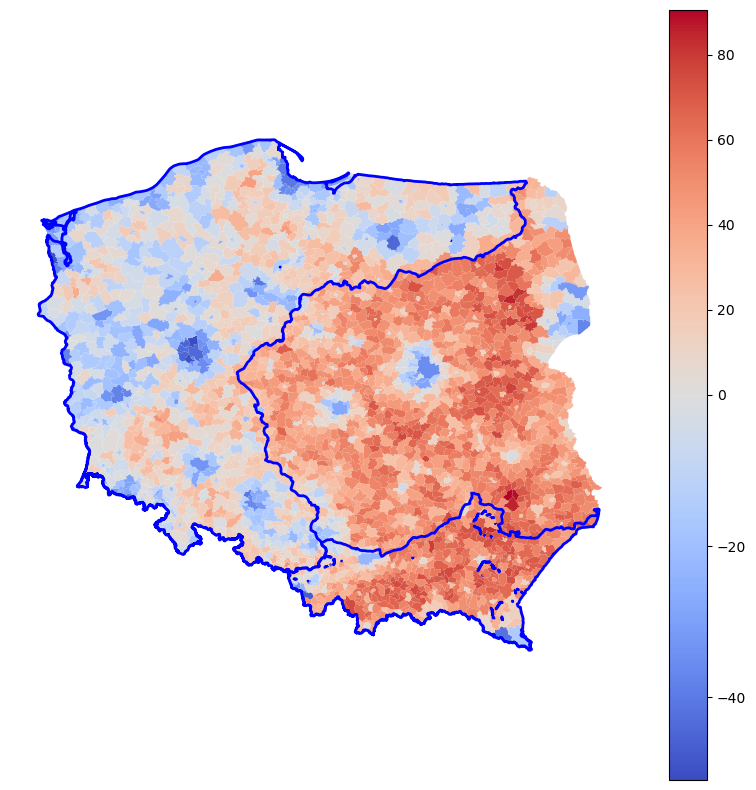

In [126]:
#wczytuje mapy granic Austrii i Niemiec z okresu po rozbiorze Polski i ograniczam ich granice do obszaru dzisiejszej Polski
#źródło: https://censusmosaic.demog.berkeley.edu/data/historical-gis-files
aust=gpd.read_file('data/Austro_Hungarian_Empire_1910_v.1.0.shp',encoding='utf-8')
aust=aust.to_crs(gminy2.crs)
aust= gpd.overlay(gminy2,aust)
aust['uni']=1
aust=aust[['uni','geometry']].dissolve('uni')

niem=gpd.read_file('data/German_Union (GER)_1870_v.1.0.shp',encoding='utf-8')
niem=niem.to_crs(gminy2.crs)
niem= gpd.overlay(gminy2,niem)
niem['uni']=1
niem=niem[['uni','geometry']].dissolve('uni')

import matplotlib.pyplot as plt
from matplotlib import colors
import mapclassify

divnorm=colors.TwoSlopeNorm(vmin=min(gminy2['przewaga']), vcenter=0., vmax=max(gminy2['przewaga']))

fig, ax = plt.subplots(1, figsize=(10, 10))
gminy2.plot(ax=ax, linewidth=0.5, column='przewaga',cmap='coolwarm', norm=divnorm, legend=True)
niem.plot(ax=ax, edgecolor='blue', linewidth=2., color=(0, 0,0,0))
aust.plot(ax=ax, edgecolor='blue', linewidth=2., color=(0, 0,0,0))
ax.axis('off')

Na mapie powyżej mapie 'widać zabory'. Na dawnych ziemiach zaboru pruskiego Duda uzyskał zdecydowanie mniejszą przewagę/częściej przgrywał w porównaniu z ziemiami zaborów rosyjskich i austriackich (nie licząc obszarów miejskich, gdzie wygrywał Traskowski)

In [127]:
#tworzę jednolity obiekt z granic gmin, w których wygrał Duda
gminy2['win']=np.where(gminy2['przewaga']>0,'Duda','Trzask')
gminy2_duda=gminy2[gminy2['win']=='Duda']
gminy2_duda['uni']=1
gminy2_duda=gminy2_duda[['uni','geometry']].dissolve('uni')


D:\Aplikacje\Anaconda\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


(13.621739949250056, 24.646927985750054, 48.71032801055004, 55.12813517445004)

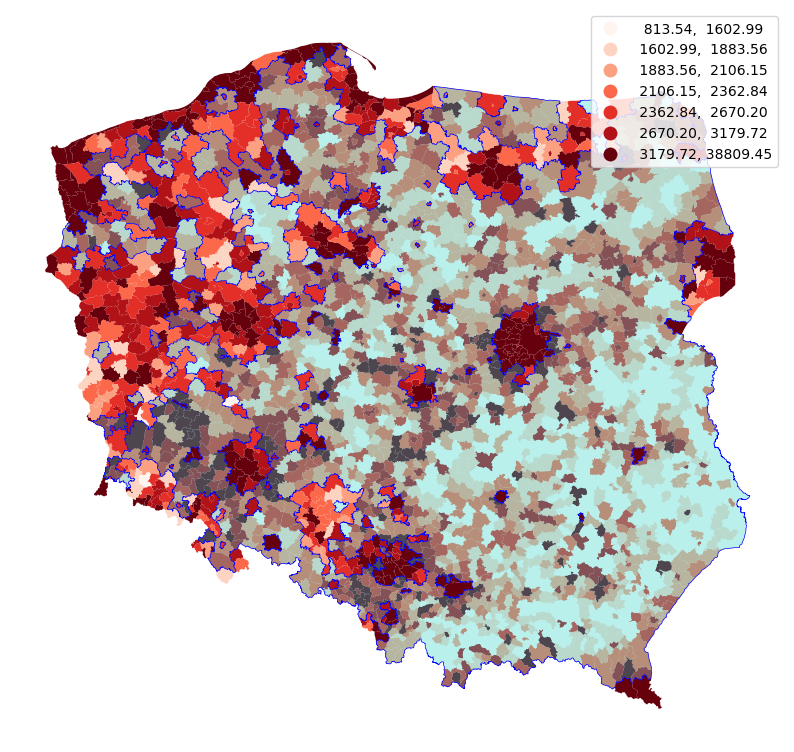

In [128]:
fig, ax = plt.subplots(1, figsize=(10, 10))
gminy2.plot(ax=ax, linewidth=0.5, column='fin_wlasne', cmap='Reds', scheme='quantiles', legend=True,k=7)
gminy2_duda.plot(ax=ax, edgecolor='blue', linewidth=0.5, color=(0.1, 0.9, 0.9, 0.3))
ax.axis('off')

W zacieniowanych gminach wygrał Duda, w pozostałych Trzaskowski.
Na powyższej mapie widać, że Trzaskowski nie wygrał w praktycznie żadnej gminie z niskim poziomem dochodów mieszkańców - wszystkie jasno-pokolorowane gminy znajdują się w zacienionym obszarze.
Niestety przy takim rozdrobnieniu danych, nanoszenie ich na mapę robi się strasznie nieczytelne, dlatego dalej rezygnuję z nanoszenia danych na mapę.

Sprawdzę korelację pomiędzy wynikiem wyborów, a utworzonymi przeze mnie zmiennymi

In [129]:
gminy2.columns

Index(['JPT_KOD_JE', 'JPT_NAZWA_', 'geometry', 'Kod', 'fin_ogolem',
       'fin_wlasne', 'fin_wlasne_udzial', 'fin_niewlasne', 'Nazwa', 'stopa',
       'stopa_k', 'stopa_m', 'stopa_pow50', 'stopa_do25', 'stopa_do30',
       'udział_długotrwałe', 'gmina', 'typ_gm', 'kod', 'pop', 'duda', 'trzask',
       'przewaga', 'win'],
      dtype='object')

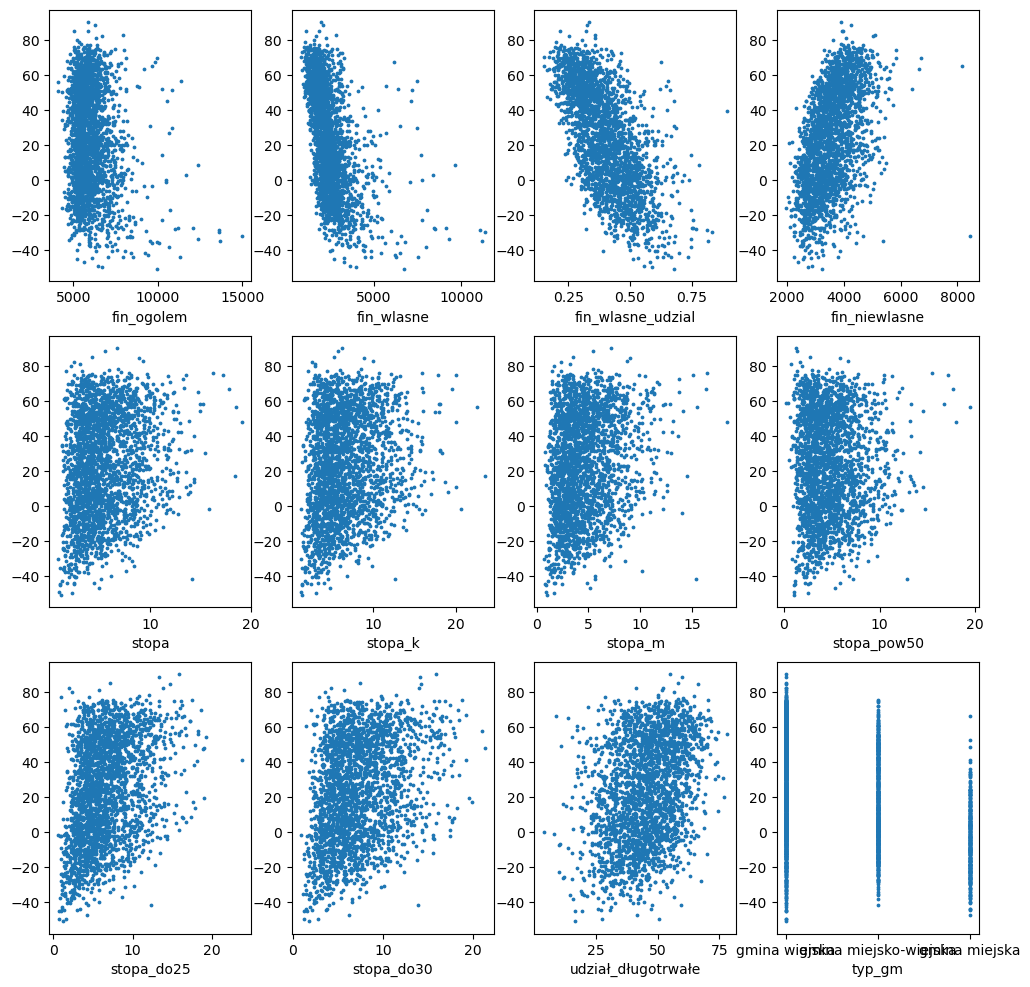

In [130]:
#%matplotlib inline
plt.rcParams['figure.figsize'] = [12,12]
fig = plt.figure()

ax1=fig.add_subplot(341)   # top left
ax1.scatter('fin_ogolem','przewaga', data=gminy2[gminy2['fin_ogolem']<20000],s=3) #wyrzucenie obserwacji odstającej
ax1.set_xlabel("fin_ogolem")

ax2=fig.add_subplot(342)   # top left
ax2.scatter('fin_wlasne','przewaga', data=gminy2[gminy2['fin_wlasne']<20000],s=3) #wyrzucenie obserwacji odstającej
ax2.set_xlabel("fin_wlasne")

ax3=fig.add_subplot(343)   # top left
ax3.scatter('fin_wlasne_udzial','przewaga',  data=gminy2,s=3)
ax3.set_xlabel("fin_wlasne_udzial")

ax4=fig.add_subplot(344)   # top left
ax4.scatter('fin_niewlasne','przewaga',  data=gminy2,s=3)
ax4.set_xlabel("fin_niewlasne")

ax5=fig.add_subplot(345)   # top left
ax5.scatter('stopa','przewaga',  data=gminy2,s=3)
ax5.set_xlabel("stopa")

ax6=fig.add_subplot(346)   # top left
ax6.scatter('stopa_k', 'przewaga', data=gminy2,s=3)
ax6.set_xlabel("stopa_k")

ax7=fig.add_subplot(347)   # top left
ax7.scatter('stopa_m', 'przewaga', data=gminy2,s=3)
ax7.set_xlabel("stopa_m")

ax8=fig.add_subplot(348)   # top left
ax8.scatter('stopa_pow50', 'przewaga', data=gminy2,s=3)
ax8.set_xlabel("stopa_pow50")

ax9=fig.add_subplot(349)   # top left
ax9.scatter('stopa_do25', 'przewaga', data=gminy2,s=3)
ax9.set_xlabel("stopa_do25")

ax10=fig.add_subplot(3,4,10)   # top left
ax10.scatter('stopa_do30', 'przewaga', data=gminy2,s=3)
ax10.set_xlabel("stopa_do30")

ax11=fig.add_subplot(3,4,11)   # top left
ax11.scatter('udział_długotrwałe', 'przewaga', data=gminy2,s=3)
ax11.set_xlabel("udział_długotrwałe")

ax12=fig.add_subplot(3,4,12)   # top left
ax12.scatter('typ_gm', 'przewaga', data=gminy2[gminy2['typ_gm']!='dzielnica w m.st. Warszawa'],s=3)
ax12.set_xlabel("typ_gm")

plt.show()

Ze scatterów widzimy, że istnieje liniowa zależność między wynikiem Dudy, a finansami gminy, najlepiej widoczna dla zmiennej fin_wlasne_udzal informującej nas, jaką część budżetu gminy stanowiły dochody z podatków, opłat itd (pełna definicja https://stat.gov.pl/metainformacje/slownik-pojec/pojecia-stosowane-w-statystyce-publicznej/2164,pojecie.html)

Drugim rzucającym się w oczy wnioskiem jest to, że wśród gmin w których Trzaskowski uzyskał najlepszy wynik nie ma gmin o wysokim udziale bezrobotnych rejestrowanych. Wniosek nie różni się dla 

Możemy również zaobserować delikatną zależność dotyczącą udziału długotrwałego bezrobocia rejestrowanego (powyżej 1 roku) - im wyższy jego udział tym wyższy wynik Dudy

Ostatni wniosek - Duda wygrał stosunkowo mniej gmin miejskich niż wiejskich i wiejsko-miejskich

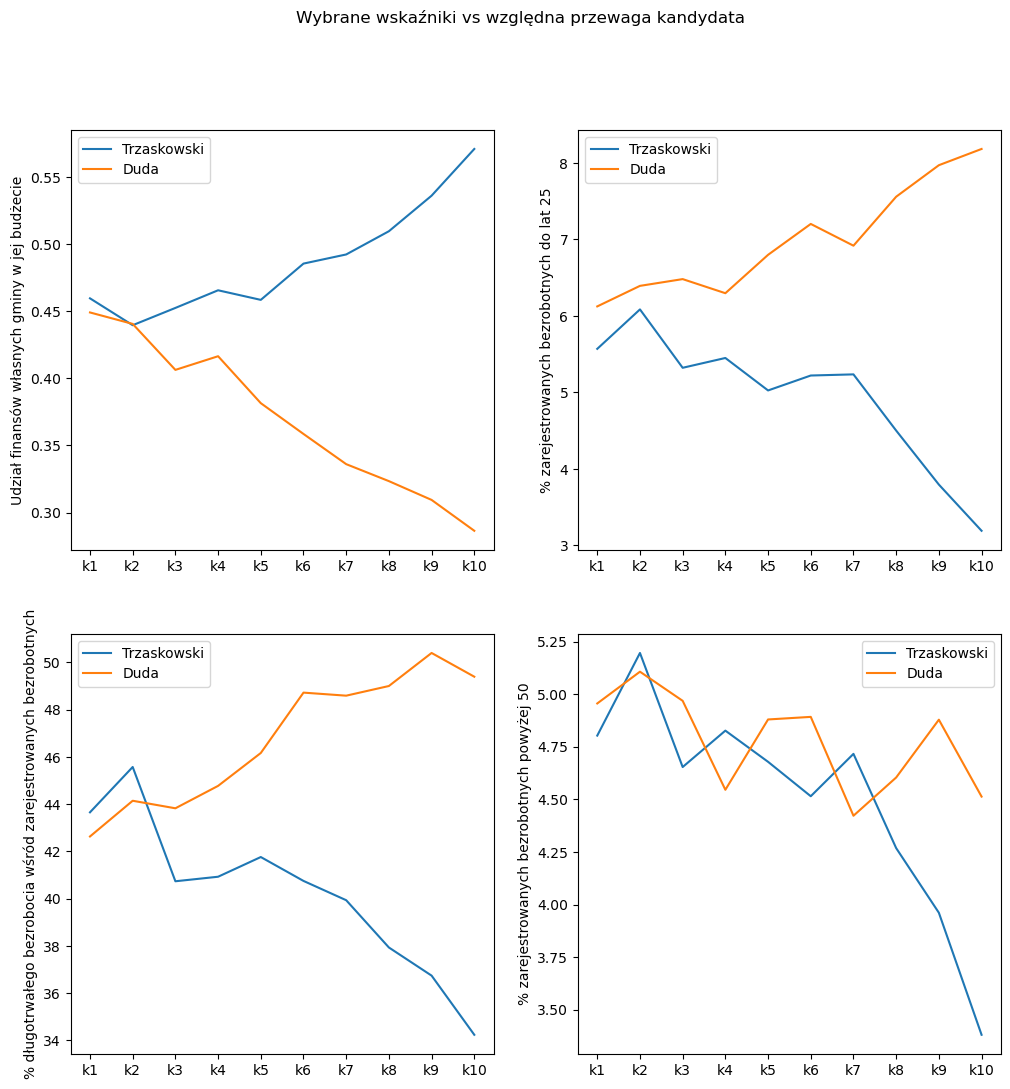

In [131]:
k=10
#w celu przedstawienia danych na wspólnych osiach grupuję gminy na k względnie równych części 
#w każdej części jest równa liczba gmin w której wygrał dany kandydat - dla Dudy w 1 części znajdzie się
#(liczba gimn, w których wygrał Duda)/k
duda=gminy2[gminy2['win']=='Duda'].copy()
duda['kwantyl']=pd.qcut(duda['przewaga'],q=k,labels=[f'k{x}' for x in range(1,k+1)])
duda_agg=duda.groupby('kwantyl').agg(przewaga_mean=('przewaga','mean'),
                                    fin_wlasne_udzial_mean=('fin_wlasne_udzial','mean'),
                                    stopa_do25_mean=('stopa_do25','mean'),
                                    udział_długotrwałe_mean=('udział_długotrwałe','mean'),
                                    stopa_pow50_mean=('stopa_pow50','mean'),
                                    ).reset_index()

trzask=gminy2[gminy2['win']=='Trzask'].copy()
trzask['przewaga']=abs(trzask['przewaga']) 
trzask['kwantyl']=pd.qcut(trzask['przewaga'],q=k,labels=[f'k{x}' for x in range(1,k+1)])
trzask_agg=trzask.groupby('kwantyl').agg(przewaga_mean=('przewaga','mean'),
                                    fin_wlasne_udzial_mean=('fin_wlasne_udzial','mean'),
                                    stopa_do25_mean=('stopa_do25','mean'),
                                    udział_długotrwałe_mean=('udział_długotrwałe','mean'),
                                    stopa_pow50_mean=('stopa_pow50','mean'),
                                        ).reset_index()


fig =plt.figure()
fig.suptitle('Wybrane wskaźniki vs względna przewaga kandydata')
plt.rcParams['figure.figsize'] = [12,12]
fig.add_subplot(221)
plt.plot(trzask_agg['kwantyl'],trzask_agg['fin_wlasne_udzial_mean'],label='Trzaskowski')
plt.plot(duda_agg['kwantyl'],duda_agg['fin_wlasne_udzial_mean'],label='Duda')
plt.ylabel('Udział finansów własnych gminy w jej budżecie',rotation =90)
#plt.xlabel('Względna przewaga kandydata')
plt.legend()
fig.add_subplot(222)
plt.plot(trzask_agg['kwantyl'],trzask_agg['stopa_do25_mean'],label='Trzaskowski')
plt.plot(duda_agg['kwantyl'],duda_agg['stopa_do25_mean'],label='Duda')
plt.ylabel('% zarejestrowanych bezrobotnych do lat 25',rotation =90)
#plt.xlabel('Względna przewaga kandydata')
plt.legend()
fig.add_subplot(223)
plt.plot(trzask_agg['kwantyl'],trzask_agg['udział_długotrwałe_mean'],label='Trzaskowski')
plt.plot(duda_agg['kwantyl'],duda_agg['udział_długotrwałe_mean'],label='Duda')
plt.ylabel('% długotrwałego bezrobocia wśród zarejestrowanych bezrobotnych',rotation =90)
#plt.xlabel('Względna przewaga kandydata')
plt.legend()
fig.add_subplot(224)
plt.plot(trzask_agg['kwantyl'],trzask_agg['stopa_pow50_mean'],label='Trzaskowski')
plt.plot(duda_agg['kwantyl'],duda_agg['stopa_pow50_mean'],label='Duda')
plt.ylabel('% zarejestrowanych bezrobotnych powyżej 50',rotation =90)
#plt.xlabel('Względna przewaga kandydata')
plt.legend()

Na pierwszym wykresie widzimy, że im większy średni udział finansów własnych gminy w budżecie tym wyższą przewagę średnio uzyskał Trzaskowski. Dla 20% gmin z najniższą przewagą kandydatów średni udział jest zbiżony, na poziomie ok 45%, później zaczyna się rozjeżdżać.

Dla udziału długotrwałego bezrobocia wśród zarejestrowancyh bezrobotnych obserwujemy podobne zależności liniowe - im wyższa przewaga Dudy tym średni udział długotrwałego bezrobocia był wyższy. W 20% najbardziej wyrównanych gmin średni udział był na zbliżonym poziomie.

W przypadku bezrobocia rejestrowanego w grupie do 25 lat, jego średni udział był większy we wszystkich grupach gmin, w których wygrał Duda. Podobnie jak w pozostałych przypadkach, różnica zwiększa się wraz ze zwiększającą się różnicą głosów.

Na ostatnim wykresie widzimy, że dla udziału zarejestrowanych bezrobotnych powyżej 50 lat zależność jest inna. Nie jesteśmy w stanie zaobserwować istotnych różnic czy trendów dla 80% gmin z najmniejszą różnicą głosów. W ostatnich 20% tam gdzie wygrał Trzaskowski średni udział bezrobotnych rejestrowanych powyżej 50 roku życia jest wyrażnie niższy.